[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/NouamaneTazi/number-plate-recognition/blob/main/notebooks/DETR_license_plates.ipynb)
<a href="https://colab.research.google.com/github/NouamaneTazi/number-plate-recognition/blob/main/notebooks/DETR_license_plates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tuning DETR for license plates detection

In this notebook, we are going to fine-tune [DETR](https://ai.facebook.com/blog/end-to-end-object-detection-with-transformers/) (end-to-end object detection with Transformers) on a [custom moroccan license plates dataset](https://www.kaggle.com/elmehditaf96/moroccan-vehicle-registration-plates). The goal for the model is to recognize license plates in pictures.

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/05/Screenshot-from-2020-05-27-17-48-38.png)

Also big thanks to Niels Rogge from Huggingface for his [Transformers tutorials](https://github.com/NielsRogge/Transformers-Tutorials), as well as the creators of [this notebook](https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb) and [this notebook](https://www.kaggle.com/tanulsingh077/end-to-end-object-detection-with-transformers-detr), which helped me a lot in understanding how to fine-tune DETR on a custom dataset



## Set up environment

In [1]:
!pip install -q timm pycocotools scipy
!pip install -qU pytorch-lightning transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 28.5 MB/s eta 0:00:00


## Download + preprocess data

Here we download the [license plates dataset](https://www.kaggle.com/elmehditaf96/moroccan-vehicle-registration-plates) hosted on kaggle (in [YOLOv4 format](https://github.com/AlexeyAB/darknet)) and convert it to [COCO Object Detection Format](https://cocodataset.org/#format-data).

We can use [fiftyone's converter tool](https://voxel51.com/docs/fiftyone/recipes/convert_datasets.html) for that.

For the sake of demo on kaggle we're only gonna use 20 images from that dataset.

In [ ]:
!cd ../input/coco-lp-preview/coco_lp/ && ls

desktop.ini  train  val


## Create PyTorch dataset + dataloaders

Here we define a regular PyTorch dataset. Each item of the dataset is an image and corresponding annotations. Torchvision already provides a `CocoDetection` dataset, which we can use. We only add a feature extractor (`DetrFeatureExtractor`) to resize + normalize the images, and to turn the annotations (which are in COCO format) in the format that DETR expects. It will also resize the annotations accordingly.

In [2]:
!#!/bin/bash
!kaggle datasets download fyfek1151kavya/coco-format-number-plate-dataset

Dataset URL: https://www.kaggle.com/datasets/fyfek1151kavya/coco-format-number-plate-dataset
License(s): unknown
100% 80.7M/80.7M [00:05<00:00, 22.3MB/s]
100% 80.7M/80.7M [00:05<00:00, 15.1MB/s]


In [3]:
!unzip /content/coco-format-number-plate-dataset.zip -d /content/coco-format-number-plate-dataset


Archive:  /content/coco-format-number-plate-dataset.zip
  inflating: /content/coco-format-number-plate-dataset/README.dataset.txt  
  inflating: /content/coco-format-number-plate-dataset/README.roboflow.txt  
  inflating: /content/coco-format-number-plate-dataset/test/CarLongPlate129_jpg.rf.e928edf270fed0fba46d5699d93b9fbd.jpg  
  inflating: /content/coco-format-number-plate-dataset/test/CarLongPlate131_jpg.rf.9e3730e2cd692a80f1b07ec97c5cef31.jpg  
  inflating: /content/coco-format-number-plate-dataset/test/CarLongPlate180_jpg.rf.f6e8553a572c159b108dd689c9016a86.jpg  
  inflating: /content/coco-format-number-plate-dataset/test/CarLongPlate185_jpg.rf.06d0f30fd4a2a242512eae9d25cb9c71.jpg  
  inflating: /content/coco-format-number-plate-dataset/test/CarLongPlate231_jpg.rf.0a1a8a8dab824940015f8027c8dd82b9.jpg  
  inflating: /content/coco-format-number-plate-dataset/test/CarLongPlate255_jpg.rf.7a422e2ea0429700cee4a3ce7fd4f58f.jpg  
  inflating: /content/coco-format-number-plate-dataset/test

In [4]:
!cd /content/coco-format-number-plate-dataset && ls

README.dataset.txt  README.roboflow.txt  test  train  valid


MY **MODEL**

In [ ]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


**already available model**

In [1]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "_annotations.coco.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

Based on the class defined above, we create training and validation datasets.

In [2]:
from transformers import DetrFeatureExtractor

img_folder = "/content/coco-format-number-plate-dataset"

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder=f'{img_folder}/train', feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder=f'{img_folder}/valid', feature_extractor=feature_extractor, train=False)
test_dataset = CocoDetection(img_folder=f'{img_folder}/test', feature_extractor=feature_extractor, train=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/usr/local/lib/python3.11/dist-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


As you can see, this dataset is tiny:

In [3]:
train_dataset

Dataset CocoDetection
    Number of datapoints: 3081
    Root location: /content/coco-format-number-plate-dataset/train

In [4]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of testing examples:", len(test_dataset))

Number of training examples: 3081
Number of validation examples: 579
Number of testing examples: 195


Let's verify an example by visualizing it. We can access the COCO API of the dataset by typing `train_dataset.coco`.

Image n°1509


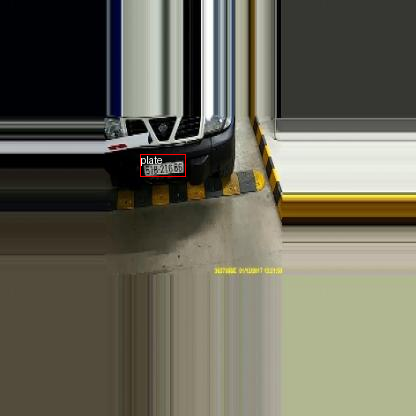

In [5]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{img_folder}/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

Next, let's create corresponding dataloaders. We define a custom `collate_fn` to batch images together. As DETR resizes images to have a min size of 800 and a max size of 1333, images can have different sizes. We pad images (`pixel_values`) to the largest image in a batch, and create a corresponding `pixel_mask` to indicate which pixels are real (1)/which are padding (0).  

In [6]:
train_dataset.coco

In [7]:
cats

{0: {'id': 0, 'name': 'plate', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'licence', 'supercategory': 'plate'},
 2: {'id': 2, 'name': 'plate', 'supercategory': 'plate'}}

In [8]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=10, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=10)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=10)

batch = next(iter(train_dataloader))

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Let's verify the keys of a single batch:

In [9]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

Let's verify the shape of the `pixel_values`, and check the `target`::

In [10]:
pixel_values, target = train_dataset[0]

In [11]:
pixel_values.shape

torch.Size([3, 800, 800])

In [12]:
print(target)

{'size': tensor([800, 800]), 'image_id': tensor([0]), 'class_labels': tensor([2]), 'boxes': tensor([[0.3960, 0.2758, 0.2440, 0.1094]]), 'area': tensor([17079.3262]), 'iscrowd': tensor([0]), 'orig_size': tensor([416, 416])}


## Train the model using PyTorch Lightning

Here we define a `LightningModule`, which is an `nn.Module` with some extra functionality.

For more information regarding PyTorch Lightning, I recommend the [docs](https://pytorch-lightning.readthedocs.io/en/latest/?_ga=2.35105442.2002381006.1623231889-1738348008.1615553774) as well as the [tutorial notebooks](https://github.com/PyTorchLightning/lightning-tutorials/tree/aeae8085b48339e9bd9ab61d81cc0dc8b0d48f9c/.notebooks/starters).

You can of course just train the model in native PyTorch as an alternative.

In [13]:
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch

class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

We could start Tensorboard if we'd like to monitor the training, since Pytorch Lightning automatically logs to it.

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Here we define the model, and verify the outputs.

In [14]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

The logits are of shape `(batch_size, num_queries, number of classes + 1)`. We model internally adds an additional "no object class", which explains why we have one additional output for the class dimension.

In [15]:
outputs.logits.shape

torch.Size([10, 100, 4])

Next, let's train! We train for a maximum of 300 training steps, and also use gradient clipping. You can refresh Tensorboard above to check the various losses.

In [18]:
from pytorch_lightning import Trainer
from tqdm.notebook import tqdm
from torchmetrics import Accuracy

trainer = Trainer(max_epochs=7, gradient_clip_val=0.1)
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.009   Total estimated model params size (MB)
0         Modules in train mode
399       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


In [19]:
trainer.callback_metrics  # Returns a dictionary of logged metrics


{'training_loss': tensor(0.6104),
 'train_loss_ce': tensor(0.0032),
 'train_loss_bbox': tensor(0.0354),
 'train_loss_giou': tensor(0.2150),
 'train_cardinality_error': tensor(0.),
 'validation_loss': tensor(0.5802),
 'validation_loss_ce': tensor(0.0206),
 'validation_loss_bbox': tensor(0.0270),
 'validation_loss_giou': tensor(0.2122),
 'validation_cardinality_error': tensor(0.2522)}

For the training I used [Sagemaker Studio Lab](https://studiolab.sagemaker.aws/) which offers performant GPUs. So don't hesitate to reduce the batch size if you run into memory errors.

In [20]:
!nvidia-smi

Sun Jan 26 12:28:46 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0              34W /  70W |    293MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Inference (+ visualization)

Let's visualize the predictions of DETR on the first image of the validation set.

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256

{'training_loss': tensor(1.8356),
 'train_loss_ce': tensor(0.3049),
 'train_loss_bbox': tensor(0.1331),
 'train_loss_giou': tensor(0.4327),
 'train_cardinality_error': tensor(1.),
 'validation_loss': tensor(1.7175),
 'validation_loss_ce': tensor(0.3136),
 'validation_loss_bbox': tensor(0.1101),
 'validation_loss_giou': tensor(0.4267),
 'validation_cardinality_error': tensor(1.)}

In [22]:
import torch
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [23]:
def visualize_predictions(image, outputs, threshold=0.9, keep_highest_scoring_bbox=False):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  if keep_highest_scoring_bbox:
    keep = probas.max(-1).values.argmax()
    keep = torch.tensor([keep])

  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [24]:
it = iter(range(1500))

torch.Size([1, 3, 800, 800])


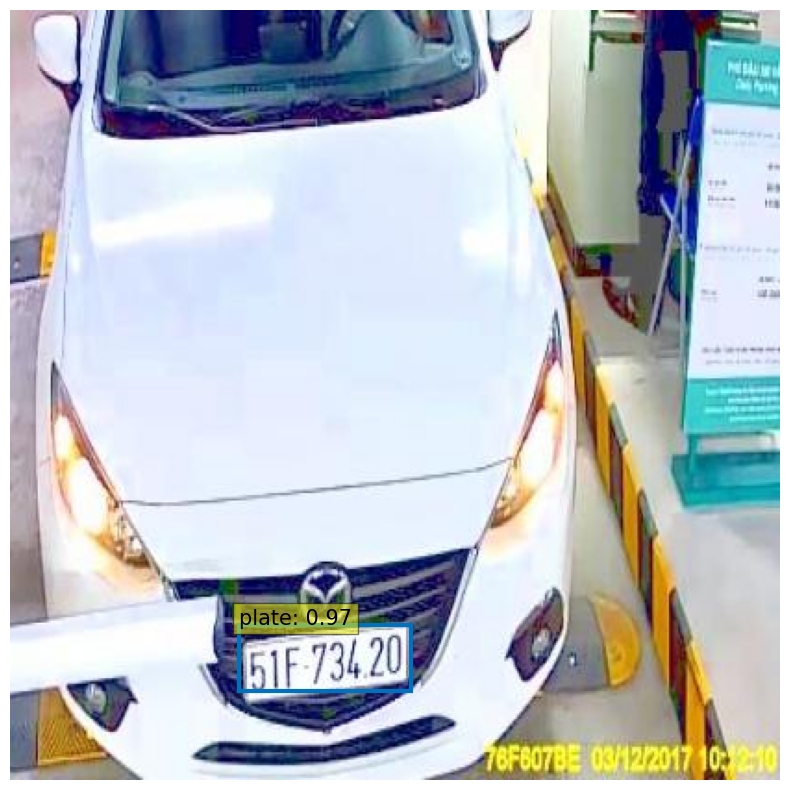

In [25]:
#We can use the image_id in target to know which image it is
pixel_values, target = val_dataset[next(it)]

pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

# forward pass to get class logits and bounding boxes
outputs = model(pixel_values=pixel_values, pixel_mask=None)

image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{img_folder}/valid', image['file_name']))

visualize_predictions(image, outputs, threshold=0.3, keep_highest_scoring_bbox=True)

In [26]:
TEST_DATASET = test_dataset

In [28]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 14.9 MB/s eta 0:00:00


In [29]:
import supervision as sv


In [30]:
from transformers import DetrForObjectDetection, DetrImageProcessor
CHECKPOINT = 'facebook/detr-resnet-50'

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)


In [31]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame_ground_truth = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# inference
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(device)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(device)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=0.5,
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results)
labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
frame_detections = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)


# %matplotlib inline # Remove this line, we won't use it anymore

# Combine both images side by side and display
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(cv2.cvtColor(frame_ground_truth, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title('Ground Truth')

axs[1].imshow(cv2.cvtColor(frame_detections, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title('Detections')

Image #173


AttributeError: type object 'Detections' has no attribute 'from_coco_annotations'

In [32]:
!pip install -q coco_eval

  Preparing metadata (setup.py) ... done


In [33]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [36]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

evaluator = CocoEvaluator(coco_gt=TEST_DATASET.coco, iou_types=["bbox"])

print("Running evaluation...")

for idx, batch in enumerate(tqdm(test_dataloader)):
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/20 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.737
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.456
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.596
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.434
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.451
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.451
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.301
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.502
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [37]:
trainer.save_checkpoint("detr_model.ckpt")

I hope you find this notebook useful. If you have any questions, please don't hesitate to contact me.

Also note that this is only the license plate detection part, we can also use this model for the characters segmentation , followed by an OCR. (you can check [this paper](https://www.researchgate.net/publication/353034031_An_Improved_Character_Recognition_Framework_for_Containers_Based_on_DETR_Algorithm) for more info)

![](https://www.mdpi.com/sensors/sensors-21-04612/article_deploy/html/images/sensors-21-04612-g001.png)

Unfortunately I'm quite busy lately, but I'll try to post the rest of the notebooks soon.